In [89]:
import numpy as np
import matplotlib.pyplot as plt
from ortools.graph import pywrapgraph

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

from mpl_toolkits.mplot3d import Axes3D

from tqdm.notebook import tqdm
from scipy.optimize import linear_sum_assignment
import matplotlib

In [2]:
def num_correct_matches(pie, pie_star, num_inliers):
    return np.sum(pie[:num_inliers] == pie_star[:num_inliers])

def num_in_out_matches(pie, pie_star, num_inliers):
    return np.sum(pie[:num_inliers] >= num_inliers)

def num_out_out_matches(pie, pie_star, num_inliers):
    return np.sum(pie[num_inliers:] >= num_inliers)

def num_out_in_matches(pie, pie_star, num_inliers):
    return np.sum((pie[num_inliers:] < num_inliers) & (pie[num_inliers:] >= 0))

def dist(x, y):
    d =  np.linalg.norm(x - y) ** 2
    return d if d > 0 else 0.0000001

def error_rate(p1, p2):
    return np.sum(p1 != p2) / len(p2)

def precision_k(pie, pie_star, num_matched):
    pie = np.array(pie)
    pie_star = np.array(pie_star)
    k = len(pie_star)
    return np.sum(pie[:k] == pie_star) / num_matched

def precision(pie, pie_star, k):
    pie = np.array(pie)
    pie_star = np.array(pie_star)
    return np.sum(pie[:k] == pie_star) / k

def recall_k(pie, pie_star, num_matched):
    pie = np.array(pie)
    pie_star = np.array(pie_star)
    k = len(pie_star)
    return np.sum(pie[k:] != -1) / num_matched

def dist_nosquare(x, y):
    d =  np.linalg.norm(x - y)
    return d if d > 0 else 0.0000001

def kappa_all(theta, theta_hash, pie, sigma):
    n = len(theta)
    m = len(theta_hash)
    min_dist = np.inf
    for j in range(m):
        for i in range(n):
            if i in pie and pie[i] == j:
                continue
            min_dist = min(min_dist, dist_nosquare(theta[i], theta_hash[j]))
    return min_dist / sigma / np.sqrt(2)

def kappa(theta_hash, pie):
    n = len(pie)
    m = len(theta_hash)
    min_dist = np.inf
    for j in range(m):
        for i in range(n):
            if pie[i] == j:
                continue
            min_dist = min(min_dist, dist(theta_hash[j], theta_hash[pie[i]]) ** (1/2))
    return min_dist

def kappa_hat(theta_hash, sigma_hash, pie):
    n = len(pie)
    m = len(theta_hash)
    min_dist = np.inf
    for j in range(m):
        for i in range(n):
            if pie[i] == j:
                continue
            min_dist = min(min_dist, 
                           dist(theta_hash[j], theta_hash[pie[i]]) ** (1/2) / ((sigma_hash[j] ** 2 + sigma_hash[pie[i]] ** 2) ** (1/2)))
    return min_dist

def kappa_outlier(theta_hash, sigma_hash, pie):
    n = len(pie)
    m = len(theta_hash)
    im_comp = [i for i in range(m) if i not in pie]
    min_dist = np.inf
    for i in range(n):
        for j in im_comp:
            min_dist = min(min_dist, 
                           dist(theta_hash[pie[i]], theta_hash[j]) ** (1/2) / ((sigma_hash[j] ** 2 + sigma_hash[pie[i]] ** 2) ** (1/2)))
    return min_dist

def kappa_outlier_outlier(theta_hash, sigma_hash, theta, sigma, k):
    m, n = len(sigma_hash), len(sigma)
    min_dist = np.inf
    for i in range(k, m):
        for j in range(k, n):
            min_dist = min(min_dist, 
                           dist(theta_hash[i], theta[j]) ** (1/2) / ((sigma_hash[i] ** 2 + sigma[j] ** 2) ** (1/2)))
    return min_dist
    

def outlier_detection_error(star, prediction):
    return sum([1 for i in prediction[:len(star)] if i != -1 and i not in star]) / len(star)

def kappa_max(theta_hash, sigma_hash, pie):
    n = len(pie)
    m = len(theta_hash)
    max_dist = -np.inf
    for j in range(m):
        for i in range(n):
            if pie[i] == j:
                continue
            max_dist = max(max_dist, 
                           dist(theta_hash[j], theta_hash[pie[i]]) ** (1/2) / ((sigma_hash[j] ** 2 + sigma_hash[pie[i]] ** 2) ** (1/2)))
    return max_dist

def mincostflowcost(X, X_hash, pie, k):
    s = 0
    for i in range(k):
        j = pie[i]
        if j != -1:
            s += dist(X[i], X_hash[j])
    return s



In [75]:
def greedy(X, X_hash, num_to_match=None, return_cost=False, progress_bar=False):
    costs = [0]
    cost = 0
    if num_to_match is None:
        num_to_match = len(X)
    n, m = len(X), len(X_hash)
    M = np.zeros((n, m))
    if progress_bar:
        iterable = tqdm(enumerate(X), desc='Calculating pairwise distances', total=n)
    else:
        iterable = enumerate(X)
    for i, x in iterable:
        for j, x_hash in enumerate(X_hash):
            M[i, j] = dist(x, x_hash)
    pie = -1 * np.ones(n, dtype=np.int32)
    for _ in range(num_to_match):
        i, j = np.unravel_index(M.argmin(), M.shape)
        pie[i] = j
        cost += M[i, j]
        costs.append(cost)
        M[:, j] = np.inf
        M[i, :] = np.inf

    if return_cost:
        return pie, costs

    return pie

def LSS(X, X_hash):
    M = np.zeros((len(X), len(X_hash)))
    for i, x in enumerate(X):
        for j, x_hash in enumerate(X_hash):
            M[i, j] = dist(x, x_hash)
            
    row_ind, col_ind = linear_sum_assignment(M)
    return col_ind

def LSNS(X, X_hash, sigma_hash):
    M = np.zeros((len(X), len(X_hash)))
    for i, x in enumerate(X):
        for j, x_hash in enumerate(X_hash):
            M[i, j] = dist(x, x_hash) / (sigma_hash[j] ** 2 + sigma_hash[i] ** 2) ** (1/2)
    
    row_ind, col_ind = linear_sum_assignment(M)
    return col_ind

def LSL(X, X_hash):
    M = np.zeros((len(X), len(X_hash)))
    for i, x in enumerate(X):
        for j, x_hash in enumerate(X_hash):
            M[i, j] = np.log(dist(x, x_hash))
    
    row_ind, col_ind = linear_sum_assignment(M)
    return col_ind


def MinCostFlow(X, X_hash, k = None, scale = 10**4, sigma=None):
    n, m = (len(X), len(X_hash))
    M = np.zeros(n * m)
    for i, x in enumerate(X):
        for j, x_hash in enumerate(X_hash):
            M[i * m + j] = dist(x, x_hash)
    
    if sigma is not None:
        M = M / 2 / sigma / sigma

#     if sigma is not None:
#         scale = scale * 2 * sigma * sigma

    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    
    start_nodes = np.concatenate((np.zeros(n), 
                                  np.repeat(np.arange(1, n + 1), m), 
                                  np.arange(n + 1, n + m + 1))).astype(int).tolist()
    
    end_nodes = np.concatenate((np.arange(1, n + 1), 
                                np.tile(np.arange(n + 1, n + m + 1), n), 
                                np.ones(m) * (n + m + 1))).astype(int).tolist()
    
    num_overall_edges = (n + 1) * (m + 1) - 1
    capacities = np.ones(num_overall_edges).astype(int).tolist()
    costs = (np.concatenate((np.zeros(n), M * scale, np.zeros(m))).astype(int).tolist())
    
    source = 0
    sink = n + m + 1
    if k is None:
        num_to_match = n
    else:
        num_to_match = k
    supplies = [num_to_match] + [0] * (n + m) + [-num_to_match]
    
    # Add each arc.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i],
                                                    end_nodes[i], capacities[i],
                                                    costs[i])
    # Add node supplies.
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])
    
    status = min_cost_flow.Solve()
    assignment = -1 * np.ones(n, dtype=np.int32)
    cost = min_cost_flow.OptimalCost() / scale
    
    if status == min_cost_flow.OPTIMAL:
        for arc in range(min_cost_flow.NumArcs()):
        
            if min_cost_flow.Tail(arc) != source and min_cost_flow.Head(arc) != sink:

                if min_cost_flow.Flow(arc) > 0:
                    assignment[min_cost_flow.Tail(arc) - 1] = min_cost_flow.Head(arc) - n - 1
    else:
        print('There was an issue with the min cost flow input.')
        print(f'Status: {status}')

    return assignment, cost 


# Data Generation

In [5]:
def generate_theta_sigma_hash_outlier_both_sides(m, n, k, d, pie_star, tau=1, sigma_amp=1):
    theta_hash = np.random.normal(0, tau, size = (m, d))
    theta = np.random.normal(0, tau, size = (n, d))
    theta[:k] = theta_hash[pie_star]
    for i in range(m):
        if i in pie_star:
            continue
        theta_hash[i, :] += np.ones((d,)) * tau
        
    for i in range(k, n):
        theta[i, :] += np.ones((d,)) * 2 * tau
    
    sigma_hash = np.ones((m,)) * sigma_amp
    sigma = np.ones((n,)) * sigma_amp
    
    return theta_hash, sigma_hash, theta, sigma


## Experiment 1

In [11]:
def precision_vs_separation(n=100, k=50, d=50, tau=1, sig=1):
    m = n
    res = {}

    pie_star = np.arange(k)
    
    theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides(m, n, k, d, pie_star, tau, sigma_amp=sig)
#     theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides_cauchy(m, n, k, d, pie_star, tau, sigma_amp=sig)

    X = theta + (sigma * np.random.normal(size=(d, n))).T
    X_hash = theta_hash + (sigma_hash * np.random.normal(size=(d, m))).T
    res['kappa_all'] = kappa_all(theta, theta_hash, pie_star, sigma=sig)
#     res['theorem1_rhs'] = theorem1_rhs(n, k, d, 0.1)

    MinCostFlow_pie, cost = MinCostFlow(X, X_hash, k)

    res['precision'] = precision(MinCostFlow_pie, pie_star, k)
    res['cost'] = cost

    return res

In [15]:
def recovery_for_k_lessthan_kstar(n=100, k=50, d=50, tau=1, progress_bar=True, sigma_amp=1.):
    m = n
    res = {}

    pie_star = np.arange(k)
    
    theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides(
        m, n, k, d, pie_star, tau, sigma_amp=sigma_amp)
    
#     theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides_cauchy(
#         m, n, k, d, pie_star, tau, sigma_amp=sigma_amp)

    X = theta + (sigma * np.random.normal(size=(d, n))).T
    X_hash = theta_hash + (sigma_hash * np.random.normal(size=(d, m))).T
    res['kappa_all'] = kappa_all(theta, theta_hash, pie_star, sigma=sigma_amp)
    res['precision'] = []
    
    for i in range(1, k + 1):
        MinCostFlow_pie, cost = MinCostFlow(X, X_hash, i)
        
        res['precision'].append(precision_k(MinCostFlow_pie, pie_star, i))

    return res

In [14]:
num_exp = 200
n=100
k=60
d=100
amp=1.5

precision_vs_separation_sig_1 = [precision_vs_separation(n, k, d, tau = amp * (1 -  i / num_exp), sig=1) for i in tqdm(range(num_exp))]
precision_vs_separation_sig_2 = [precision_vs_separation(n, k, d, tau = 2 * amp * (1 -  i / num_exp), sig=2) for i in tqdm(range(num_exp))]



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
num_exp = 200
n=100
k=60
d=100
amp = 3

recovery_sig_1 = [recovery_for_k_lessthan_kstar(n, k, d, progress_bar=False, tau = amp * (1 -  (i / num_exp) ** 3), sigma_amp=1) for i in tqdm(range(num_exp))]
recovery_sig_2 = [recovery_for_k_lessthan_kstar(n, k, d, progress_bar=False, tau = amp * (1 -  (i / num_exp) ** 3), sigma_amp=2) for i in tqdm(range(num_exp))]



  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

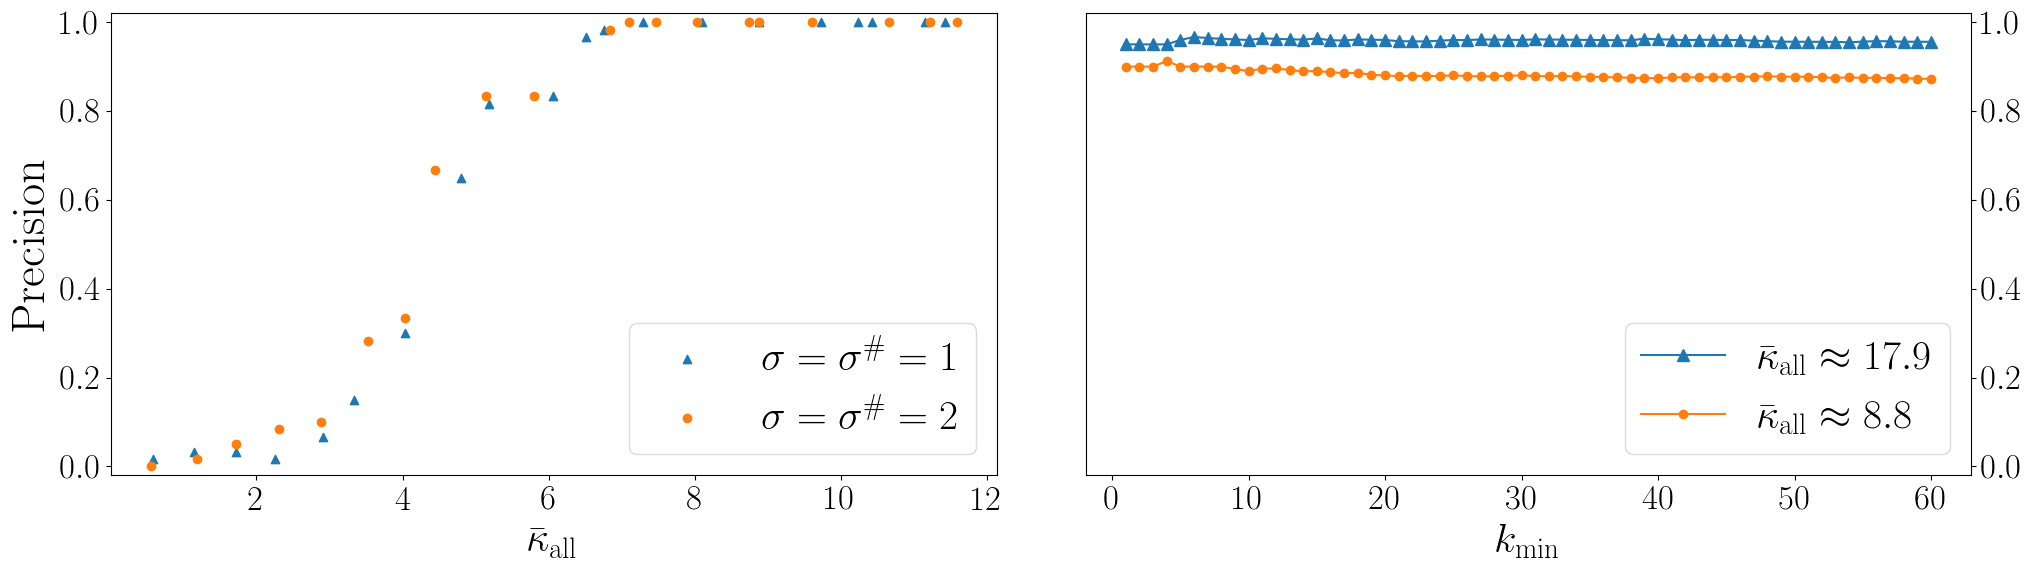

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(24, 6))

ax[0].scatter([r[r'kappa_all'] for r in precision_vs_separation_sig_1],
              [r[r'precision'] for r in precision_vs_separation_sig_1],
            label=r'$\sigma = \sigma^\# = 1$', marker = "^");
ax[0].scatter([r[r'kappa_all'] for r in precision_vs_separation_sig_2],
              [r[r'precision'] for r in precision_vs_separation_sig_2],
            label=r'$\sigma = \sigma^\# = 2$');

kappa_mean_1 = np.mean([r['kappa_all'] for r in recovery_sig_1])
kappa_mean_2 = np.mean([r['kappa_all'] for r in recovery_sig_2])

ax[1].plot(range(1, k + 1), [np.mean([r['precision'][i] for r in recovery_sig_1]) for i in range(k)],
         marker = "^", markersize=8, label=r'  $\bar\kappa_{{\mathrm{{all}}}} \approx {k:.1f}$'.format(k=kappa_mean_1));
ax[1].plot(range(1, k + 1), [np.mean([r['precision'][i] for r in recovery_sig_2]) for i in range(k)],
         marker = ".", markersize=12, label=r'  $\bar\kappa_{{\mathrm{{all}}}} \approx {k:.1f}$'.format(k=kappa_mean_2));

ax[1].set_xlabel(r'$ k_{\mathrm{min}} $', fontsize=30);

ax[1].yaxis.tick_right()
ax[0].set_ylim([-0.02, 1.02]);
ax[1].set_ylim([-0.02, 1.02]);

ax[0].set_xlabel(r'$ \bar\kappa_{\mathrm{all}} $', fontsize=30);

ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[1].tick_params(axis='both', which='major', labelsize=25)

ax[0].set_ylabel(r'$\mathrm{Precision} $', fontsize=35);

# # plt.ylim([0, 1.1])
ax[0].legend(fontsize=30, loc='lower right', framealpha=0.7);
ax[1].legend(fontsize=30, loc='lower right', framealpha=0.7);

plt.subplots_adjust(wspace=0.1, hspace=10)


## Experiment 2

In [49]:
def threshold(n, d, alpha=0.01):
    return  4 * max(d * np.log(4 * n * n / alpha) ** (1/2),
                   np.log(8 * n * n / alpha) )


In [50]:
def k_star_estimation(n, k, d, tau=1, progress_bar=True, sigma_amp=1):
    m = n
    res = {}

    pie_star = np.arange(k)
    
    theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides(
        m, n, k, d, pie_star, tau, sigma_amp=sigma_amp)

    X = theta + (sigma * np.random.normal(size=(d, n))).T
    X_hash = theta_hash + (sigma_hash * np.random.normal(size=(d, m))).T
    res['kappa_all'] = kappa_all(theta, theta_hash, pie_star, sigma=sigma_amp)
    
    thr = threshold(n, d)    
    MinCostFlow_pie_prev, cost_prev = MinCostFlow(X, X_hash, n)
    
    for i in range(n - 1, 0, -1):
        MinCostFlow_pie, cost = MinCostFlow(X, X_hash, i)
        if cost_prev - cost <= (d + thr) * sigma_amp * sigma_amp:
            break
        MinCostFlow_pie_prev, cost_prev = MinCostFlow_pie, cost

    res['k_alpha'] = i + 1

    return res

In [57]:
num_exp = 200
n=100
k=60
d=100
amp = 6

kstar_est_rs_1 = [k_star_estimation(n, k, d, progress_bar=False, tau = 1 * amp * (1 -  (i / num_exp)), sigma_amp=1) for i in tqdm(range(num_exp))]


  0%|          | 0/20 [00:00<?, ?it/s]

In [53]:
amp = 12

kstar_est_rs_2 = [k_star_estimation(n, k, d, progress_bar=False, tau = 1 * amp * (1 -  (i / num_exp)), sigma_amp=2) for i in tqdm(range(num_exp))]


  0%|          | 0/20 [00:00<?, ?it/s]

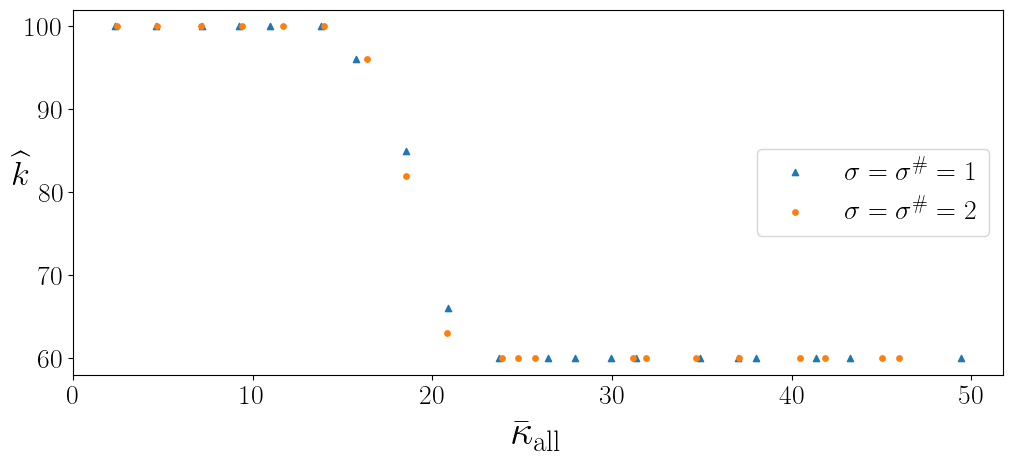

In [62]:
plt.figure(figsize=(12, 5))

plt.scatter([r[r'kappa_all'] for r in kstar_est_rs_1], [r[r'k_alpha'] for r in kstar_est_rs_1], s=20, marker='^',
            label=r'$\sigma = \sigma^\# = 1$')#, c=[r[r'k_alpha'] for r in rs]);
plt.scatter([r[r'kappa_all'] for r in kstar_est_rs_2], [r[r'k_alpha'] for r in kstar_est_rs_2], s=15,
            label=r'$\sigma = \sigma^\# = 2$')#, c=[r[r'k_alpha'] for r in rs]);

plt.xticks(fontsize=20)
plt.xlabel(r'$ \bar\kappa_{\mathrm{all}} $', fontsize=30);

ticks, labels = plt.yticks()
plt.yticks(ticks[1::2], fontsize=20)
plt.ylabel(r'$ \widehat{k}$', fontsize=25, rotation=0);
plt.legend(fontsize=20, loc='center right');

plt.gcf().subplots_adjust(bottom=0.15)

plt.subplots_adjust(bottom=0.15)

plt.savefig('k_alpha.pdf', dpi=10, format='pdf')


## Experiment 3

In [80]:
def lambda_nmda(n, m, d, alpha = 0.01):
    return 4 * max(np.power(d * np.log(4 * n * m / alpha), 1 / 4),
                   np.power(8 * np.log(4 * n * m / alpha), 1 / 2) )

def k_sig_joint_est(X, X_hash, matcher=greedy):
    n = len(X)
    m = len(X_hash)
    d = len(X[0])
    lambda_nmd = lambda_nmda(n, m, d)
    lbd = np.square(lambda_nmd) / 4
    gamma = np.square(lambda_nmd) / 4 / d / 8
    res = {}
    
    _, costs = matcher(X, X_hash, num_to_match=n, return_cost=True)
    
    for k in range(1, n - 1):
        sigma_hat_sq = costs[k] / k / d
        if costs[k + 1] - costs[k] > (d + lbd) * sigma_hat_sq / (1 - gamma):
            break
            
    res['k_alpha'] = k
    res['sigma_hat'] = np.sqrt(sigma_hat_sq / 2)
    return res, costs

In [81]:
def estimate_sigma_sq(X, X_hash, k, d, gamma = 1.95):
    _, cost = MinCostFlow(X, X_hash, k)
    return cost / (d * k  - gamma * np.sqrt(k * d)) # / 2

In [82]:
def joint_estimation(n, k, d, tau=1, progress_bar=True, sig=1):
    m = n
    res = {}

    pie_star = np.arange(k)
    
    theta_hash, sigma_hash, theta, sigma = generate_theta_sigma_hash_outlier_both_sides(m, n, k, d, pie_star, tau, sig)

    X = theta + (sigma * np.random.normal(size=(d, n))).T
    X_hash = theta_hash + (sigma_hash * np.random.normal(size=(d, m))).T
    
    res, _ = k_sig_joint_est(X, X_hash)
    res['kappa_all'] = kappa_all(theta, theta_hash, pie_star, sigma = sig)
    

    return res

In [84]:
joint_estimation(n, k, d, progress_bar=False, tau = 4, sig = 2)

{'k_alpha': 98,
 'sigma_hat': 3.422835401082145,
 'kappa_all': 15.598447567373634}

In [86]:
num_exp = 100
n=100
k=60
d=100
tau_amp = 16

joint_estimation_rs_1 = [joint_estimation(n, k, d, progress_bar=False, tau = tau_amp * (1 -  (i / num_exp )), sig = 1) for i in tqdm(range(num_exp))]
joint_estimation_rs_2 = [joint_estimation(n, k, d, progress_bar=False, tau = 2 * tau_amp * (1 -  (i / num_exp )), sig = 2) for i in tqdm(range(num_exp))]


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

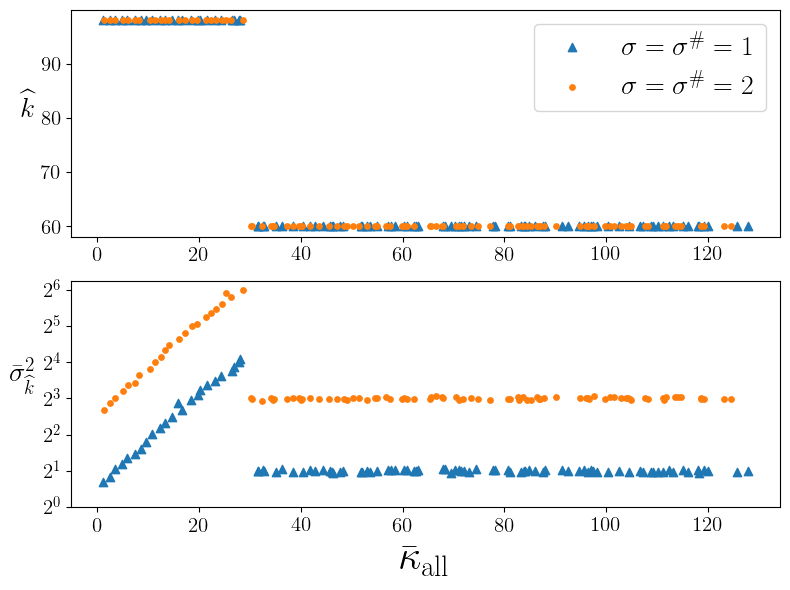

In [91]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

ax[0].scatter([r[r'kappa_all'] for r in joint_estimation_rs_1], [r[r'k_alpha'] for r in joint_estimation_rs_1], 
              label=r'$ \sigma = \sigma^\# = 1$', marker='^')#, c=[r[r'k_alpha'] for r in rs]);

ax[1].scatter([r[r'kappa_all'] for r in joint_estimation_rs_1], [r[r'sigma_hat']**2 * 2 for r in joint_estimation_rs_1],
              label=r'$ \sigma = \sigma^\# = 1$',  marker='^')


ax[0].scatter([r[r'kappa_all'] for r in joint_estimation_rs_2], [r[r'k_alpha'] for r in joint_estimation_rs_2], s = 15, 
              label=r'$ \sigma = \sigma^\# = 2$')

ax[1].scatter([r[r'kappa_all'] for r in joint_estimation_rs_2], [r[r'sigma_hat']**2 * 2 for r in joint_estimation_rs_2], s=15,
              label=r'$ \sigma = \sigma^\# = 2$')

ax[1].set_yscale(matplotlib.scale.LogScale(ax[1], base=2))

ax[1].set_yticks([1.000e+00, 2, 4.000e+00, 8, 1.600e+01, 32, 6.400e+01])

ax[1].set_xlabel(r'$ k_{\mathrm{min}} $', fontsize=30);

ax[1].set_xlabel(r'$ \bar\kappa_{\mathrm{all}} $', fontsize=30);

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[0].set_ylabel(r'$ \widehat{k} ~~\, $', fontsize=20, rotation=0, labelpad=10);
ax[1].set_ylabel(r'$ \bar{\sigma}^2_{\widehat{k}} $', fontsize=20, rotation=0, labelpad=15);

plt.gcf().subplots_adjust(bottom=0.2)

plt.subplots_adjust(bottom=0.2)
ax[0].legend(fontsize=20)

plt.subplots_adjust(wspace=0.3, hspace=0.)
plt.tight_layout()
# plt.savefig('joint_estimation.pdf', dpi=10, format='pdf')
